In [1]:
from diffusers import DiffusionPipeline, UNet2DModel, DDPMScheduler, StableDiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image
import torch
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from PIL import Image
import os

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

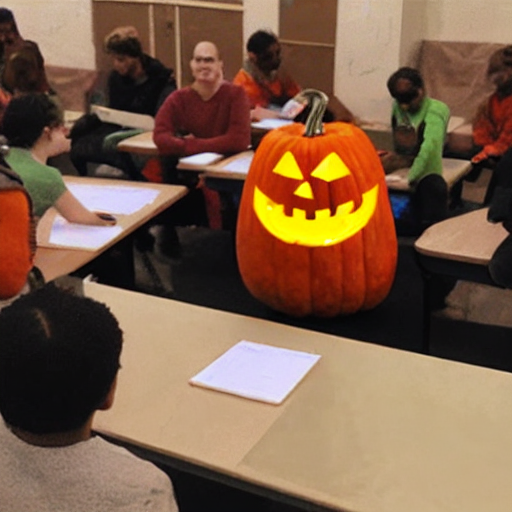

In [2]:
# Example of text prompted Stable Diffusion

torch.manual_seed(1)
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True).to("cuda")
image = pipeline("A pumpkin teaching a class on machine learning").images[0]
image.save("output/pumpkin.png")
display(image);

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/eclee/.conda/envs/pnpdm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/100 [00:00<?, ?it/s]

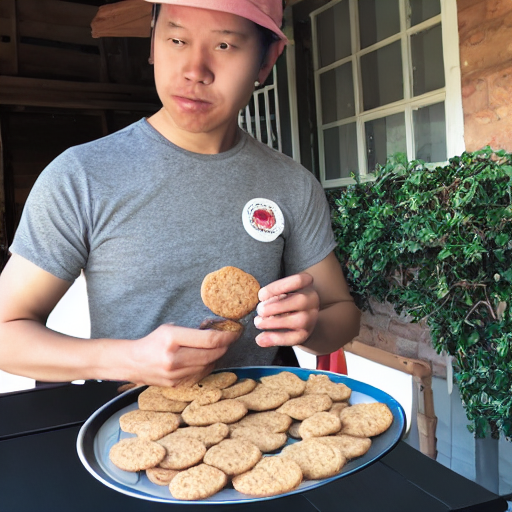

In [3]:
# Example of image as conditional

pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter-full-face_sd15.bin")
pipeline.set_ip_adapter_scale(0.5)

image = load_image("input/zachary.png")

image = pipeline(
    prompt="A photo of a man eating cookies",
    ip_adapter_image=image,
    negative_prompt="lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=100,
    generator=torch.Generator(device="cuda").manual_seed(9),
).images[0]

image.save("output/zachary_cookie.png")
display(image);

In [4]:
def tensor_to_image(image):
    image = sample.cpu().permute(0, 2, 3, 1)
    image = (image + 1.0) * 127.5
    image = image.numpy().astype(np.uint8)
    return Image.fromarray(image[0])

def image_to_tensor(image):
    mat = transforms.ToTensor()(image).unsqueeze(0)
    mat = 2 * (mat + mat.min()) / (mat.max() - mat.min()) - 1
    return mat

In [5]:
model = UNet2DModel.from_pretrained(
    "google/ddpm-cat-256",
    use_safetensors=True
).to("cuda")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.20it/s]


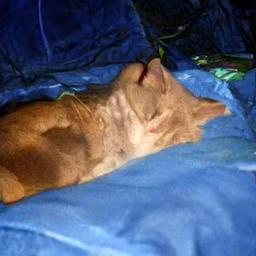

In [6]:
# Diffusion from pure noise

torch.manual_seed(5)
sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size)
sample = sample.to("cuda")

for i, t in enumerate(tqdm(scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample, t).sample

    sample = scheduler.step(residual, t, sample).prev_sample

    if (i + 1) % 50 == 0:
        tensor_to_image(sample).save(f"cat/step_{i + 1:04}.png")

display(tensor_to_image(sample))

500it [00:15, 31.94it/s]


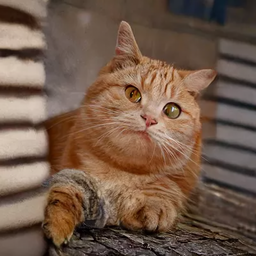

In [8]:
# Diffusion from noisy image

torch.manual_seed(7)

ts = int(scheduler.config.num_train_timesteps * 0.50)

noise = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size).to("cuda")
seed = image_to_tensor(load_image("input/cat.png")).to("cuda")
sample = scheduler.add_noise(seed, noise=noise, timesteps=torch.tensor([ts]))

tensor_to_image(sample).save("output/noisy_cat.png")

for i, t in tqdm(enumerate(reversed(range(ts)))):
    with torch.no_grad():
        residual = model(sample, t).sample

    sample = scheduler.step(residual, t, sample).prev_sample

    if (i + 1) % 50 == 0:
        tensor_to_image(sample).save(f"seeded_cat/step_{i + 1:04}.png")

display(tensor_to_image(sample))

In [9]:
def combine_images(folder_path, output_path):
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    image_files = sorted(image_files)
    
    images = [Image.open(os.path.join(folder_path, img)) for img in image_files]
    
    max_images_per_row = 5
    img_height = max(img.height for img in images)
    num_rows = (len(images) + max_images_per_row - 1) // max_images_per_row
    total_width = sum(img.width for img in images[:max_images_per_row])
    total_height = num_rows * img_height

    combined_image = Image.new("RGB", (total_width, total_height), "white")

    for index, img in enumerate(images):
        x, y = index % max_images_per_row, index // max_images_per_row
        combined_image.paste(img, (x * img.width, y * img.height))

    # Save the combined image
    combined_image.save(output_path)

In [10]:
combine_images("cat", "output/cat_diffuse.png")

In [11]:
combine_images("seeded_cat", "output/seeded_cat_diffuse.png")